In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 5.4 MB/s 
     |████████████████████████████████| 1.3 MB 39.0 MB/s 
     |████████████████████████████████| 4.9 MB 39.9 MB/s 
     |████████████████████████████████| 431 kB 46.4 MB/s 
     |████████████████████████████████| 212 kB 48.6 MB/s 
     |████████████████████████████████| 120 kB 46.9 MB/s 
     |████████████████████████████████| 115 kB 55.6 MB/s 
     |████████████████████████████████| 127 kB 57.6 MB/s 
     |████████████████████████████████| 6.6 MB 41.4 MB/s 
Mounted at /content/gdrive


In [99]:
#Just to delete de "planes" folder if there is a need to reset the dataset or its compressed form
#!rm -rf planes
#!rm -rf planes.zip

In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [45]:
with open('API_KEY.txt') as f:
    lines = f.readlines()

In [46]:
key = os.environ.get('AZURE_SEARCH_KEY', lines[0])

In [47]:
results = search_images_bing(key, 'bf 109')
ims = results.attrgot('contentUrl')
len(ims)
ims[0]

'https://aeropedia.com.au/wp-content/uploads/2019/05/Messerschmitt-Bf-109_Aeropedia-The-Encyclopedia-of-Aircraft.jpg'

In [48]:
planes_types = 'messerschmitt 109','focke wulf 190 A-1','messerschmitt 163 komet'
path = Path('planes')

In [49]:
if not path.exists():
    path.mkdir()
    for o in planes_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} plane')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [50]:
fns = get_image_files(path)
fns

(#436) [Path('planes/focke wulf 190/f2e35043-293f-4bd6-a356-5813060c57e4.jpg'),Path('planes/focke wulf 190/fe232e97-8f3b-4842-8cef-fa4e704052b7.jpg'),Path('planes/focke wulf 190/e5473965-03d6-4a4f-98e8-1de0790c0e6a.jpg'),Path('planes/focke wulf 190/52f4421f-b46d-4f27-8888-520ca780084e.jpg'),Path('planes/focke wulf 190/9a2bc16f-9cab-4635-8785-af1a384bc851.jpg'),Path('planes/focke wulf 190/010262e6-5ed3-41d2-bf79-17571448148e.jpg'),Path('planes/focke wulf 190/0a3a3a8c-8974-4e77-a47c-6c7e40733445.png'),Path('planes/focke wulf 190/f9fb42ee-e186-4534-b590-0182a75ce604.jpg'),Path('planes/focke wulf 190/ed2b9205-5c11-4a20-a5aa-7b9e455eba6a.jpg'),Path('planes/focke wulf 190/a09ec422-1131-4e2d-abc3-949c1d654550.jpg')...]

In [51]:
failed = verify_images(fns)
failed

(#4) [Path('planes/messerschmitt 109/5b830d09-f82d-406a-8b76-e8ba9026394c.jpg'),Path('planes/messerschmitt 163 komet/52af2130-987e-46d4-a244-c9f1b5844a18.jpg'),Path('planes/messerschmitt 163 komet/bb379a9c-bf18-4845-80f9-e88f1989d739.jpg'),Path('planes/messerschmitt 163 komet/05aa2388-211a-493a-bdeb-5351565c8d6e.png')]

In [52]:
failed.map(Path.unlink);

In [76]:
planes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [77]:
dls = planes.dataloaders(path)

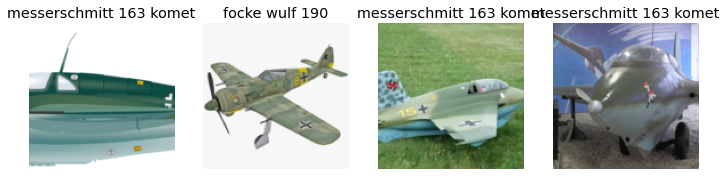

In [78]:
dls.valid.show_batch(max_n=4, nrows=1)

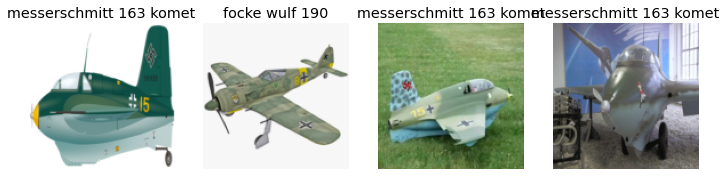

In [79]:
planes = planes.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = planes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

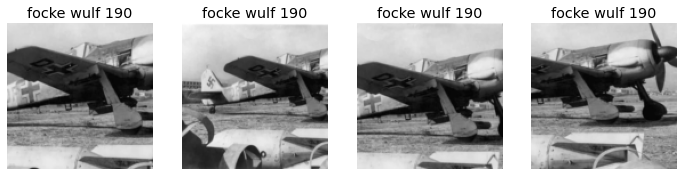

In [80]:
planes = planes.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = planes.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

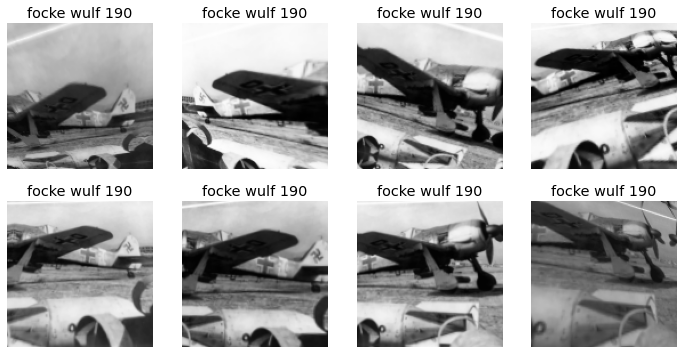

In [81]:
planes = planes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = planes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [82]:
planes = planes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = planes.dataloaders(path)

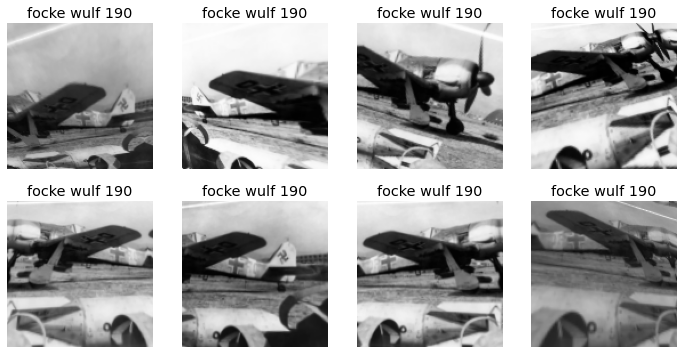

In [83]:
planes = planes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = planes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [84]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,2.024492,1.706532,0.376471,00:41


epoch,train_loss,valid_loss,accuracy,time
0,1.348978,1.124330,0.470588,00:49
1,1.348812,0.863447,0.611765,00:47
2,1.290321,0.788918,0.670588,00:48
3,1.218845,0.739363,0.682353,00:47
4,1.143576,0.698994,0.694118,00:47
5,1.071098,0.638893,0.752941,00:49
6,1.006410,0.589344,0.776471,00:48
7,0.937242,0.571797,0.764706,00:47
8,0.877759,0.563671,0.776471,00:47
9,0.836446,0.570070,0.788235,00:47


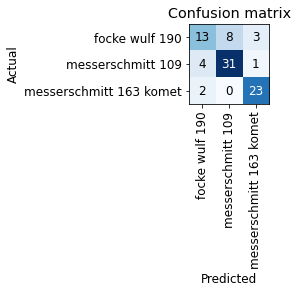

In [85]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

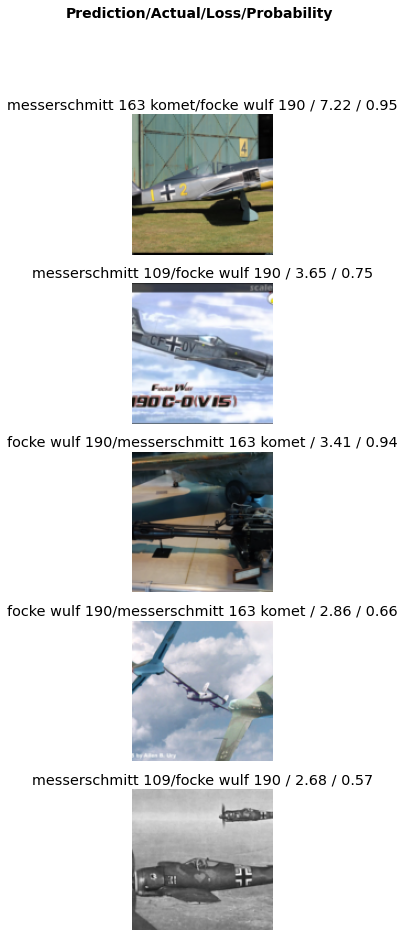

In [86]:
interp.plot_top_losses(5, nrows=5)

In [87]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [88]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [89]:
#So, for instance, to delete (`unlink`) all images selected for deletion, we would run:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#To move images for which we've selected a different category, we would run:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [90]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [91]:
#btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [92]:
#img = PILImage.create(btn_upload.data[-1])

In [93]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [96]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [97]:
#hide_output
VBox([widgets.Label('Select your plane!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [98]:
#To download the dataset if it seems correct (this code was made in google colab)
#!zip -r planes.zip planes/ 

  adding: planes/ (stored 0%)
  adding: planes/focke wulf 190/ (stored 0%)
  adding: planes/focke wulf 190/f2e35043-293f-4bd6-a356-5813060c57e4.jpg (deflated 5%)
  adding: planes/focke wulf 190/fe232e97-8f3b-4842-8cef-fa4e704052b7.jpg (deflated 0%)
  adding: planes/focke wulf 190/e5473965-03d6-4a4f-98e8-1de0790c0e6a.jpg (deflated 0%)
  adding: planes/focke wulf 190/52f4421f-b46d-4f27-8888-520ca780084e.jpg (deflated 0%)
  adding: planes/focke wulf 190/9a2bc16f-9cab-4635-8785-af1a384bc851.jpg (deflated 8%)
  adding: planes/focke wulf 190/010262e6-5ed3-41d2-bf79-17571448148e.jpg (deflated 0%)
  adding: planes/focke wulf 190/0a3a3a8c-8974-4e77-a47c-6c7e40733445.png (deflated 1%)
  adding: planes/focke wulf 190/f9fb42ee-e186-4534-b590-0182a75ce604.jpg (deflated 1%)
  adding: planes/focke wulf 190/ed2b9205-5c11-4a20-a5aa-7b9e455eba6a.jpg (deflated 1%)
  adding: planes/focke wulf 190/a09ec422-1131-4e2d-abc3-949c1d654550.jpg (deflated 1%)
  adding: planes/focke wulf 190/cdd0ecaa-0ba7-4409-bc78